# 1. Environment Setup

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\alexa\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

## 1.1 Clean Data

In [3]:
data = pd.read_csv('e:\Academic\EAS_8803_Data\EAS_8803_Data\ENSO_Data\ENSO.csv')

# Remove rows with null values
data.dropna(inplace=True)

# Drop columns: 'date', 'year', 'month', and any season columns mentioned
# Adjust the column names to match those in your dataset
cols_to_drop = ['Date', 'Year', 'Month', 'Season (2-Month)', 'Season (3-Month)', 'Season (12-Month)']
existing_cols_to_drop = [col for col in cols_to_drop if col in data.columns]
data = data.drop(columns=existing_cols_to_drop, errors='ignore')

## 1.2 Encode Data

In [4]:
def encode_enso(value):
    if 'E' in value.upper():
        return 0
    elif 'N' in value.upper():
        return 1
    elif 'L' in value.upper():
        return 2
    else:
        # If there are unexpected values, handle gracefully
        return np.nan

if 'ENSO Phase-Intensity' in data.columns:
    data['ENSO'] = data['ENSO Phase-Intensity'].apply(encode_enso)
    data.drop(columns=['ENSO Phase-Intensity'], inplace=True)
    
data.head()

Global Temperature Anomalies  Nino 1+2 SST  Nino 1+2 SST Anomalies  \
384                          0.11         24.28                   -0.24   
385                          0.21         25.38                   -0.72   
386                          0.11         25.22                   -1.38   
387                          0.21         24.57                   -1.16   
388                          0.18         24.00                   -0.62   

     Nino 3 SST  Nino 3 SST Anomalies  Nino 3.4 SST  Nino 3.4 SST Anomalies  \
384       25.84                  0.17         26.65                    0.08   
385       26.26                 -0.11         26.54                   -0.20   
386       26.92                 -0.25         27.09                   -0.14   
387       27.52                 -0.05         27.83                    0.02   
388       27.70                  0.49         28.37                    0.49   

     Nino 4 SST  Nino 4 SST Anomalies    TNI   PNA  OLR  SOI  MEI.v2  ONI  \
384       28.01                 -0.21 -1.067 -1.75  0.9  1.2    -0.4 -0.1   
385       27.99                 -0.11 -1.466 -1.20  0.1  0.3    -0.6  0.1   
386       28.18                 -0.05 -1.922 -1.66 -0.6  0.6    -0.3  0.2   
387       28.61                  0.10 -2.359 -2.08  0.0  0.1     0.1  0.5   
388       29.19                  0.40 -2.364 -0.53  0.4 -0.3     0.7  0.7   

     ENSO  
384     0  
385     0  
386     0  
387     0  
388     0

## 1.3 Visualize Data

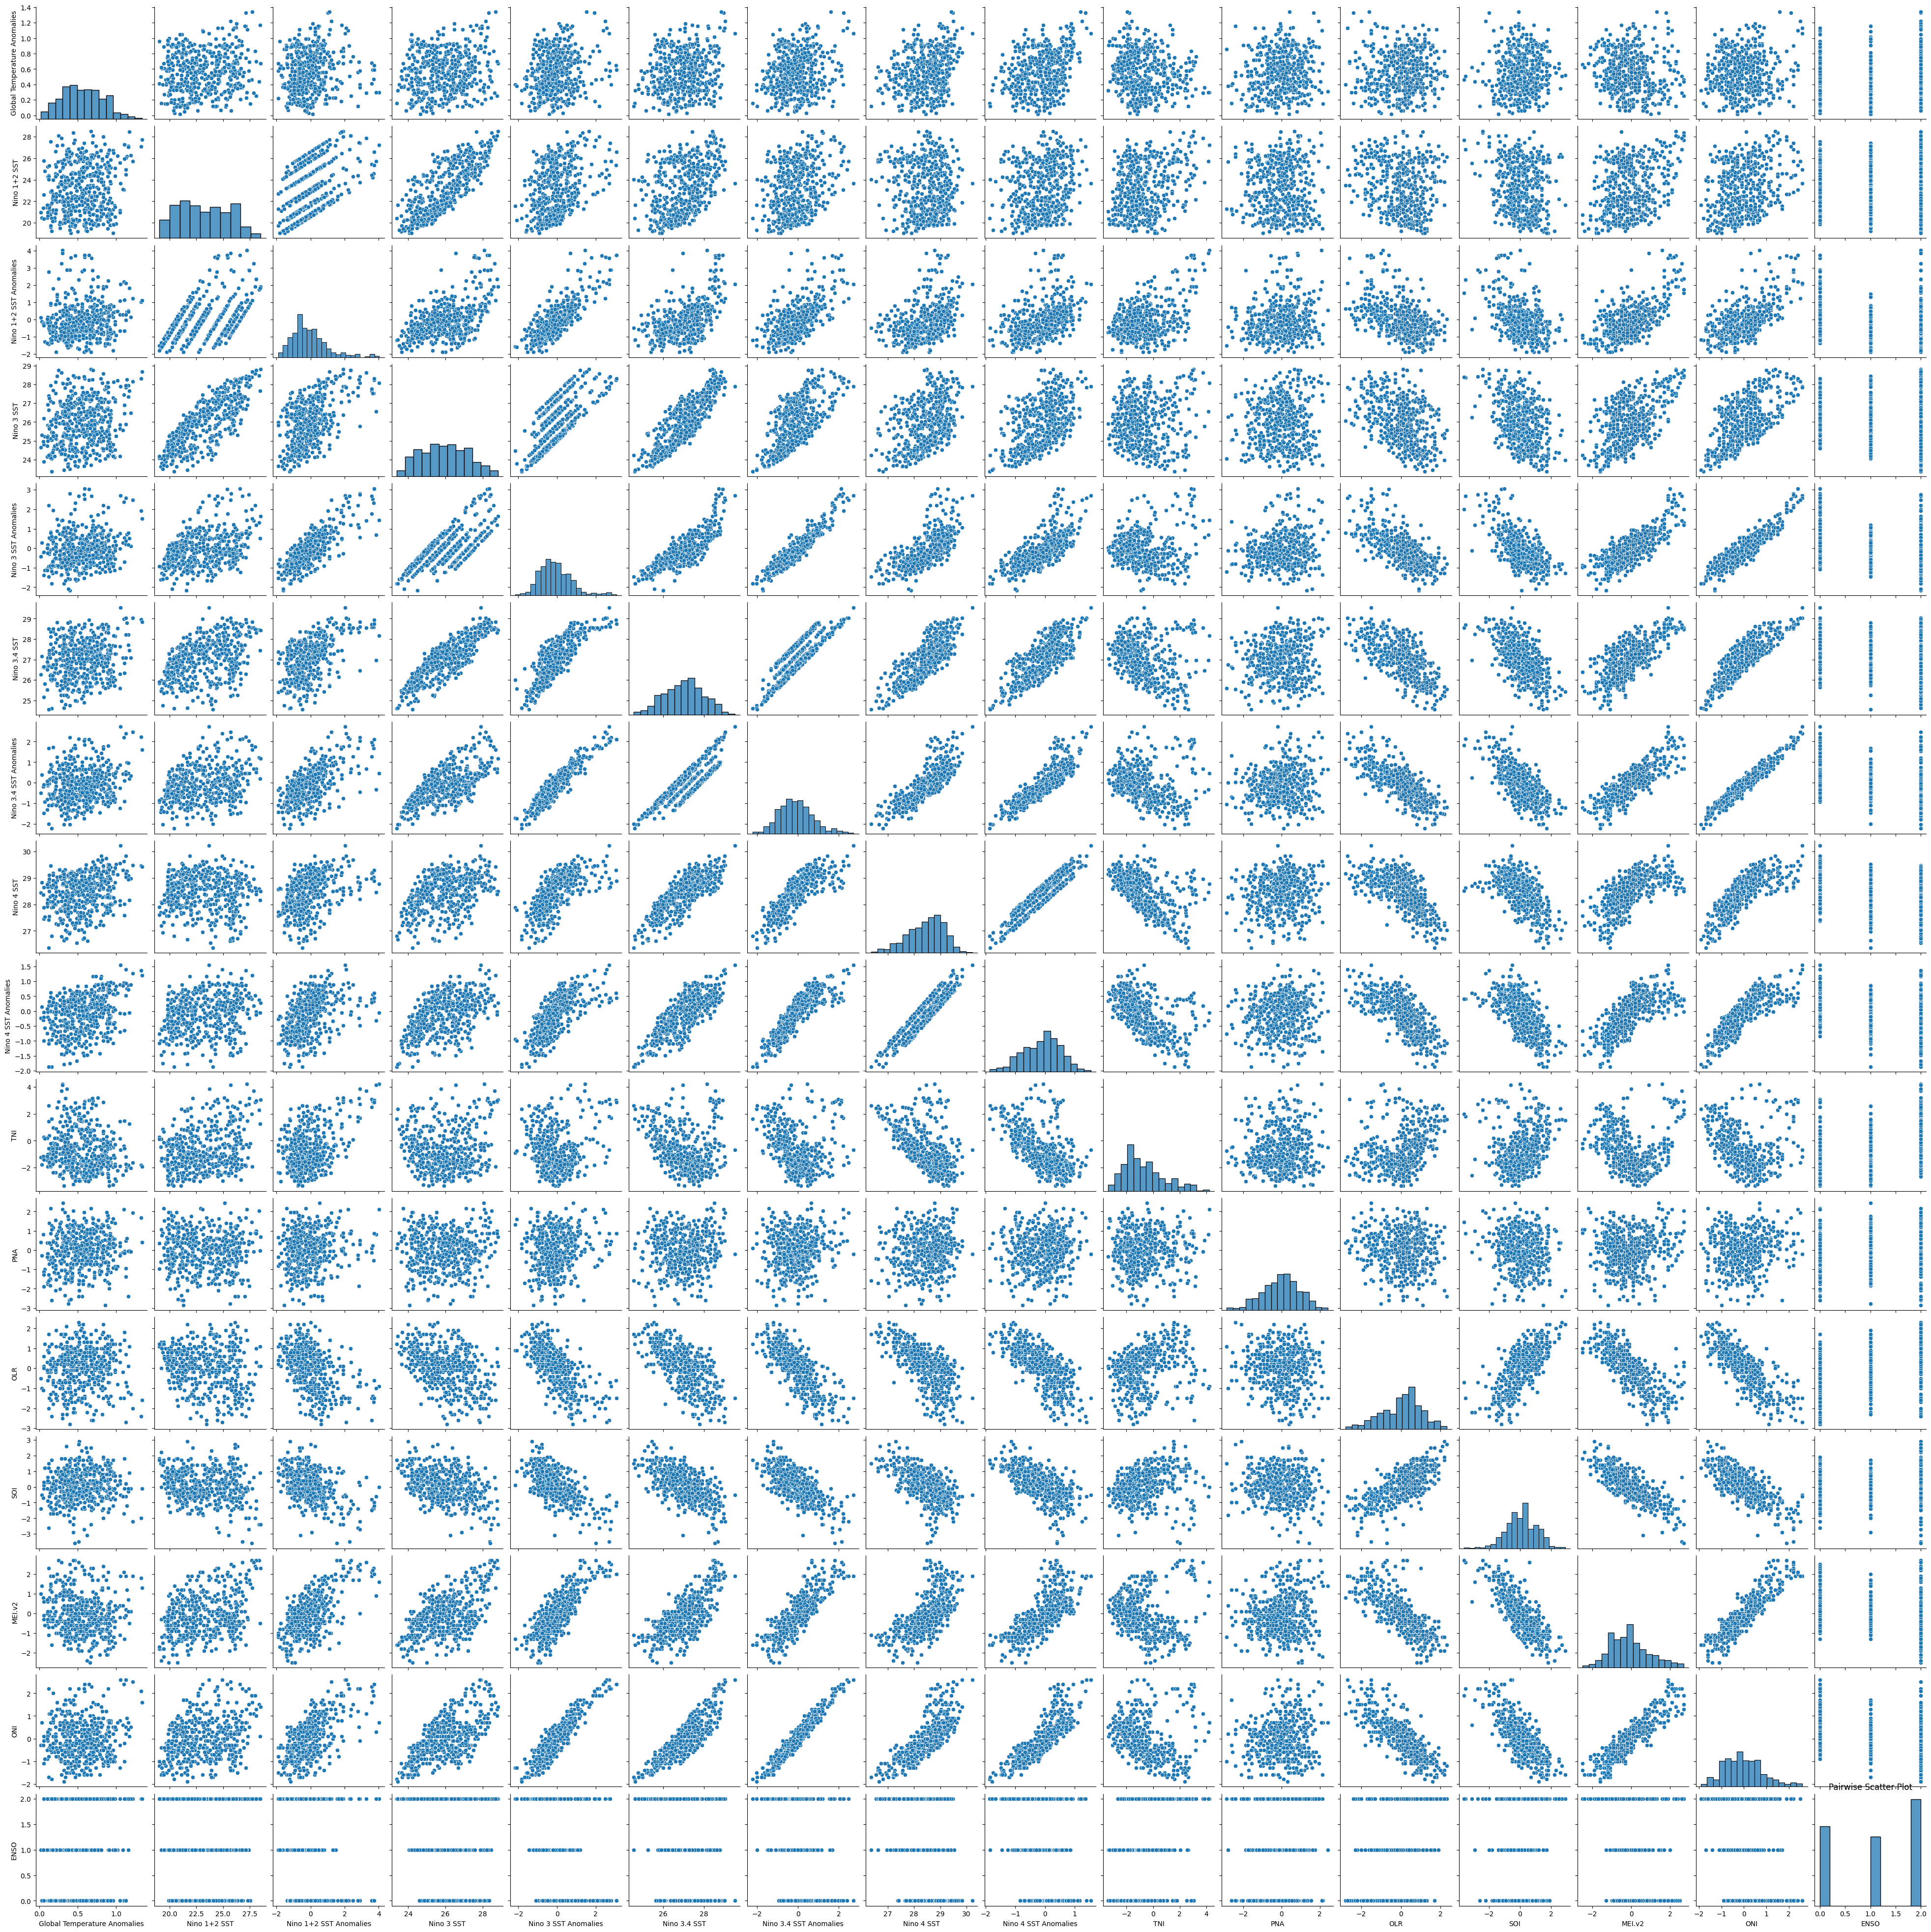

In [5]:
sns.pairplot(data)
plt.title("Pairwise Scatter Plot")
plt.show()

## 1.4 Standardize Data

In [8]:
# Prepare data
X = data.drop(columns=['ENSO'])
y = data['ENSO']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Dimesnionality Reduction

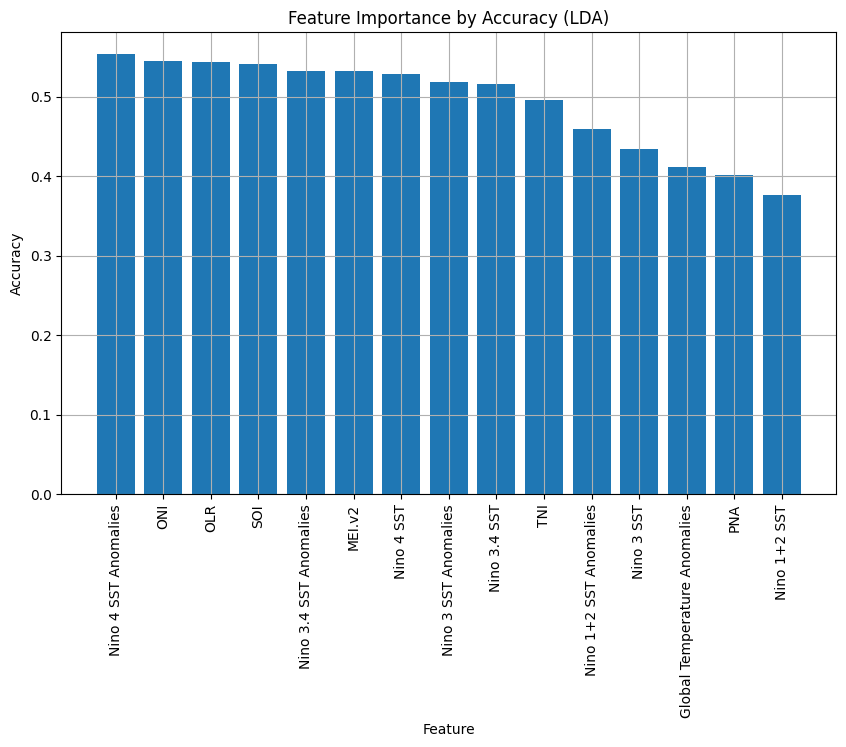

In [9]:
# Train LDA model with all features
lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled, y)

# Evaluate importance of each feature using cross-validation
feature_scores = {}
for feature in X.columns:
    score = cross_val_score(lda, X[[feature]], y, cv=5, scoring='accuracy').mean()
    feature_scores[feature] = score

# Create a DataFrame to rank features by their importance
feature_importances = pd.DataFrame(list(feature_scores.items()), columns=['Feature', 'Accuracy'])
feature_importances = feature_importances.sort_values(by='Accuracy', ascending=False)

# Visualize the feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Accuracy'])
plt.xticks(rotation=90)
plt.title("Feature Importance by Accuracy (LDA)")
plt.xlabel("Feature")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


In [23]:
features = ['ONI', 'SOI']
X_scaled = data[features]
y = data['ENSO']

# Combine X_scaled and y into a single DataFrame
data_scaled = pd.concat([X_scaled, y], axis=1)
data_scaled.head()

ONI  SOI  ENSO
384 -0.1  1.2     0
385  0.1  0.3     0
386  0.2  0.6     0
387  0.5  0.1     0
388  0.7 -0.3     0

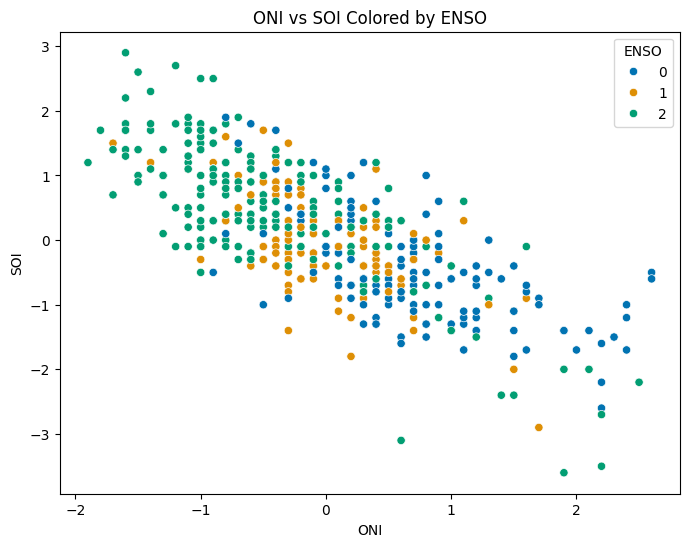

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_scaled, x='ONI', y='SOI', hue='ENSO', palette='colorblind')
plt.title("ONI vs SOI Colored by ENSO")
plt.xlabel("ONI")
plt.ylabel("SOI")
plt.legend(title="ENSO")
plt.show()

# 3. Naive Bayes Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 7. Use a Naive Bayes model to classify
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

# 4. Results

In [19]:
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.6f}")

# Confusion matrix (raw counts and percentages)
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

Accuracy: 0.581633


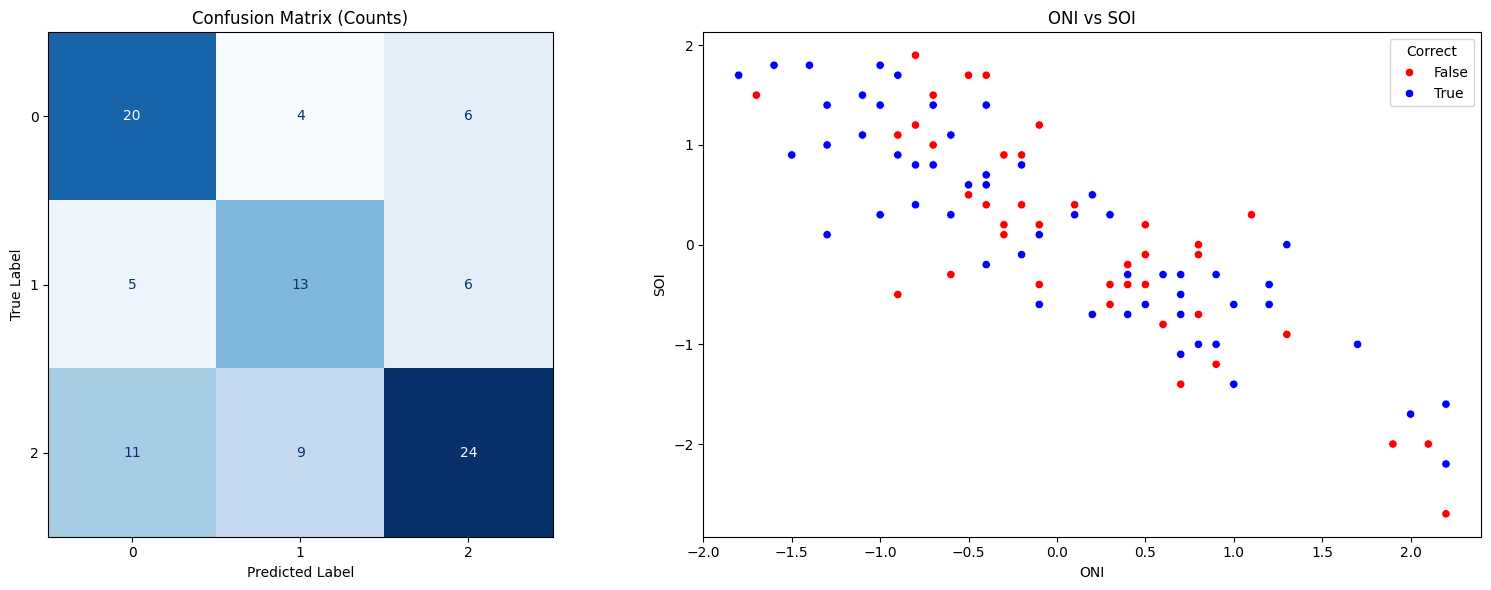

In [20]:
# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw Counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# --- 4. Plot ONI vs SOI with Correct/Incorrect Predictions ---
X_test_plot = X_test.copy()
X_test_plot['True_Label'] = y_test
X_test_plot['Pred_Label'] = y_pred
X_test_plot['Correct'] = X_test_plot['True_Label'] == X_test_plot['Pred_Label']

# ONI and SOI Columns
x_col = 'ONI'  # Replace with the actual ONI column name
y_col = 'SOI'  # Replace with the actual SOI column name

# Plot ONI vs SOI
plt.subplot(1, 2, 2)
sns.scatterplot(data=X_test_plot, x=x_col, y=y_col, hue='Correct', palette={True: 'blue', False: 'red'})
plt.title("ONI vs SOI")
plt.xlabel("ONI")
plt.ylabel("SOI")

# Adjust layout and show
plt.tight_layout()
plt.show()
